1. csv파일 범주형 , LabelEncoder 적용하여 encoding

In [13]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
import pickle

# Step 1: 데이터 읽기
raw_data_file = "/content/drive/MyDrive/BITamin Final Project - Dacon/adult_transform.csv"
raw_data = pd.read_csv(raw_data_file)

# 범주형 열 인코딩 및 LabelEncoder 객체 저장
categorical_columns = ['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'native-country', 'income']
label_encoders = {}

for column in categorical_columns:
    le = LabelEncoder()
    raw_data[column] = le.fit_transform(raw_data[column])
    label_encoders[column] = le

# LabelEncoder 객체 저장
with open('/content/drive/MyDrive/BITamin Final Project - Dacon/label_encoders.pkl', 'wb') as f:
    pickle.dump(label_encoders, f)

# 전처리된 데이터 저장
transformed_data_file = "/content/drive/MyDrive/BITamin Final Project - Dacon/adult_transform_output_CTABGAN.csv"
raw_data.to_csv(transformed_data_file, index=False)


2. 데이터 전처리 및 후처리

In [14]:
import numpy as np
import pandas as pd
from sklearn import preprocessing
from sklearn import model_selection


class DataPrep(object):

    """
    데이터 준비 클래스는 입력 데이터를 전처리하고 생성된 데이터를 후처리하는 데 사용됩니다.

    변수:
    1) raw_df -> 입력 데이터를 포함하는 데이터프레임
    2) categorical -> 범주형 열 목록
    3) log -> 지수 분포의 왜도가 있는 숫자 열 목록
    4) mixed -> 해당 범주형 모드를 포함하는 "혼합" 열 이름의 사전
    5) integer -> 소수가 없는 숫자 열 목록
    6) type -> 문제 유형(예: 분류/회귀) 및 타겟 열의 사전
    7) test_ratio -> 훈련 데이터셋 대비 테스트 데이터셋의 비율

    메소드:
    1) __init__() -> DataPrep 객체를 생성하고 훈련 알고리즘에 입력하기 위한 전처리 단계 수행
    2) inverse_prep() -> 생성된 데이터를 원본 데이터셋과 동일한 형식으로 후처리하는 메소드

    """

    def __init__(self, raw_df: pd.DataFrame, categorical: list, log: list, mixed: dict, integer: list, type: dict, test_ratio: float):

        self.categorical_columns = categorical
        self.log_columns = log
        self.mixed_columns = mixed
        self.integer_columns = integer
        self.column_types = dict()
        self.column_types["categorical"] = []
        self.column_types["mixed"] = {}
        self.lower_bounds = {}
        self.label_encoder_list = []

        # 입력 데이터를 분할하여 훈련 데이터셋 얻기
        target_col = list(type.values())[0]
        y_real = raw_df[target_col]
        X_real = raw_df.drop(columns=[target_col])
        X_train_real, _, y_train_real, _ = model_selection.train_test_split(X_real, y_real, test_size=test_ratio, stratify=y_real, random_state=42)
        X_train_real[target_col] = y_train_real

        # 빈 문자열을 na로 대체하고 na를 'empty'로 대체
        self.df = X_train_real
        self.df = self.df.replace(r' ', np.nan)
        self.df = self.df.fillna('empty')

        # 숫자 열의 빈 값을 -9999999로 대체하고 범주형 모드로 처리
        all_columns = set(self.df.columns)
        irrelevant_missing_columns = set(self.categorical_columns)
        relevant_missing_columns = list(all_columns - irrelevant_missing_columns)

        for i in relevant_missing_columns:
            if i in list(self.mixed_columns.keys()):
                if "empty" in list(self.df[i].values):
                    self.df[i] = self.df[i].apply(lambda x: -9999999 if x == "empty" else x)
                    self.mixed_columns[i].append(-9999999)
            else:
                if "empty" in list(self.df[i].values):
                    self.df[i] = self.df[i].apply(lambda x: -9999999 if x == "empty" else x)
                    self.mixed_columns[i] = [-9999999]

        # 지수 분포의 왜도가 있는 숫자 분포를 로그 변환 적용
        if self.log_columns:
            for log_column in self.log_columns:
                # 로그를 적용하기 위해 0이 아닌 값 추가
                eps = 1
                # -9999999로 표시된 결측값은 건너뜀
                lower = np.min(self.df.loc[self.df[log_column] != -9999999][log_column].values)
                self.lower_bounds[log_column] = lower
                if lower > 0:
                    self.df[log_column] = self.df[log_column].apply(lambda x: np.log(x) if x != -9999999 else -9999999)
                elif lower == 0:
                    self.df[log_column] = self.df[log_column].apply(lambda x: np.log(x + eps) if x != -9999999 else -9999999)
                else:
                    # 음수 값을 양수로 변환하여 로그 적용
                    self.df[log_column] = self.df[log_column].apply(lambda x: np.log(x - lower + eps) if x != -9999999 else -9999999)

        # 범주형 열을 라벨 인코딩을 사용하여 각 범주에 정수 값을 할당
        for column_index, column in enumerate(self.df.columns):

            if column in self.categorical_columns:
                label_encoder = preprocessing.LabelEncoder()
                self.df[column] = self.df[column].astype(str)
                label_encoder.fit(self.df[column])
                current_label_encoder = dict()
                current_label_encoder['column'] = column
                current_label_encoder['label_encoder'] = label_encoder
                transformed_column = label_encoder.transform(self.df[column])
                self.df[column] = transformed_column
                self.label_encoder_list.append(current_label_encoder)
                self.column_types["categorical"].append(column_index)

            elif column in self.mixed_columns:
                self.column_types["mixed"][column_index] = self.mixed_columns[column]

        super().__init__()

    def inverse_prep(self, data, eps=1):

        # 생성된 데이터를 데이터프레임으로 변환하고 원본 데이터셋의 열 이름을 할당
        df_sample = pd.DataFrame(data, columns=self.df.columns)

        # 원본 데이터셋에 따라 범주형 열에 할당된 라벨 인코딩을 역변환
        for i in range(len(self.label_encoder_list)):
            le = self.label_encoder_list[i]["label_encoder"]
            df_sample[self.label_encoder_list[i]["column"]] = df_sample[self.label_encoder_list[i]["column"]].astype(int)
            df_sample[self.label_encoder_list[i]["column"]] = le.inverse_transform(df_sample[self.label_encoder_list[i]["column"]])

        # 로그를 역변환하여 지수 변환을 적용하고, 비양수 숫자 열에 대해 적절히 스케일링
        # -9999999로 표시된 결측값은 무시됨
        if self.log_columns:
            for i in df_sample:
                if i in self.log_columns:
                    lower_bound = self.lower_bounds[i]
                    if lower_bound > 0:
                        df_sample[i] = df_sample[i].apply(lambda x: np.exp(x) if x != -9999999 else -9999999)
                    elif lower_bound == 0:
                        df_sample[i] = df_sample[i].apply(lambda x: np.ceil(np.exp(x) - eps) if ((x != -9999999) & ((np.exp(x) - eps) < 0)) else (np.exp(x) - eps if x != -9999999 else -9999999))
                    else:
                        df_sample[i] = df_sample[i].apply(lambda x: np.exp(x) - eps + lower_bound if x != -9999999 else -9999999)

        # 원본 데이터셋에서 소수가 없는 숫자 열을 반올림
        if self.integer_columns:
            for column in self.integer_columns:
                df_sample[column] = np.round(df_sample[column].values)
                df_sample[column] = df_sample[column].astype(int)

        # -9999999와 "empty"를 na로 다시 변환
        df_sample.replace(-9999999, np.nan, inplace=True)
        df_sample.replace('empty', np.nan, inplace=True)

        return df_sample


3. Bayesian Gaussian Mixture Model 사용하여 전처리

In [15]:
from sklearn.mixture import BayesianGaussianMixture
import pandas as pd
import numpy as np

class DataTransformer:
    def __init__(self, train_data=pd.DataFrame, categorical_list=[], mixed_dict={}, n_clusters=10, eps=0.005):
        self.meta = None
        self.train_data = train_data
        self.categorical_columns= categorical_list
        self.mixed_columns= mixed_dict
        self.n_clusters = n_clusters
        self.eps = eps
        self.ordering = []
        self.output_info = []
        self.output_dim = 0
        self.components = []
        self.filter_arr = []
        self.meta = self.get_metadata()

    def get_metadata(self):
        meta = []
        for index in range(self.train_data.shape[1]):
            column = self.train_data.iloc[:,index]
            if index in self.categorical_columns:
                mapper = column.value_counts().index.tolist()
                meta.append({
                        "name": index,
                        "type": "categorical",
                        "size": len(mapper),
                        "i2s": mapper
                })
            elif index in self.mixed_columns.keys():
                meta.append({
                    "name": index,
                    "type": "mixed",
                    "min": column.min(),
                    "max": column.max(),
                    "modal": self.mixed_columns[index]
                })
            else:
                meta.append({
                    "name": index,
                    "type": "continuous",
                    "min": column.min(),
                    "max": column.max(),
                })
        return meta

    def fit(self):
        data = self.train_data.values
        model = []
        for id_, info in enumerate(self.meta):
            if info['type'] == "continuous":
                gm = BayesianGaussianMixture(
                    n_components=self.n_clusters,
                    weight_concentration_prior_type='dirichlet_process',
                    weight_concentration_prior=0.001,
                    max_iter=100, n_init=1, random_state=42)
                gm.fit(data[:, id_].reshape([-1, 1]))
                model.append(gm)
                old_comp = gm.weights_ > self.eps
                mode_freq = pd.Series(gm.predict(data[:, id_].reshape([-1, 1]))).value_counts().keys()
                comp = [(i in mode_freq) & old_comp[i] for i in range(self.n_clusters)]
                self.components.append(comp)
                self.output_info += [(1, 'tanh'), (np.sum(comp), 'softmax')]
                self.output_dim += 1 + np.sum(comp)

            elif info['type'] == "mixed":
                gm1 = BayesianGaussianMixture(
                    n_components=self.n_clusters,
                    weight_concentration_prior_type='dirichlet_process',
                    weight_concentration_prior=0.001, max_iter=100,
                    n_init=1, random_state=42)
                gm2 = BayesianGaussianMixture(
                    n_components=self.n_clusters,
                    weight_concentration_prior_type='dirichlet_process',
                    weight_concentration_prior=0.001, max_iter=100,
                    n_init=1, random_state=42)
                gm1.fit(data[:, id_].reshape([-1, 1]))
                filter_arr = [element not in info['modal'] for element in data[:, id_]]
                self.filter_arr.append(filter_arr)
                gm2.fit(data[:, id_][filter_arr].reshape([-1, 1]))
                model.append((gm1, gm2))
                old_comp = gm2.weights_ > self.eps
                mode_freq = pd.Series(gm2.predict(data[:, id_][filter_arr].reshape([-1, 1]))).value_counts().keys()
                comp = [(i in mode_freq) & old_comp[i] for i in range(self.n_clusters)]
                self.components.append(comp)
                self.output_info += [(1, 'tanh'), (np.sum(comp) + len(info['modal']), 'softmax')]
                self.output_dim += 1 + np.sum(comp) + len(info['modal'])

            else:
                model.append(None)
                self.components.append(None)
                self.output_info += [(info['size'], 'softmax')]
                self.output_dim += info['size']
        self.model = model

    def transform(self, data):
        values = []
        mixed_counter = 0
        for id_, info in enumerate(self.meta):
            current = data[:, id_]
            if info['type'] == "continuous":
                current = current.reshape([-1, 1])
                means = self.model[id_].means_.reshape((1, self.n_clusters))
                stds = np.sqrt(self.model[id_].covariances_).reshape((1, self.n_clusters))
                features = (current - means) / (4 * stds)
                n_opts = sum(self.components[id_])
                opt_sel = np.zeros(len(data), dtype='int')
                probs = self.model[id_].predict_proba(current.reshape([-1, 1]))
                probs = probs[:, self.components[id_]]
                for i in range(len(data)):
                    pp = probs[i] + 1e-6
                    pp = pp / sum(pp)
                    opt_sel[i] = np.random.choice(np.arange(n_opts), p=pp)
                probs_onehot = np.zeros_like(probs)
                probs_onehot[np.arange(len(probs)), opt_sel] = 1
                idx = np.arange(len(features))
                features = features[:, self.components[id_]]
                features = features[idx, opt_sel].reshape([-1, 1])
                features = np.clip(features, -.99, .99)
                re_ordered_phot = np.zeros_like(probs_onehot)
                col_sums = probs_onehot.sum(axis=0)
                n = probs_onehot.shape[1]
                largest_indices = np.argsort(-1*col_sums)[:n]
                for id, val in enumerate(largest_indices):
                    re_ordered_phot[:, id] = probs_onehot[:, val]
                self.ordering.append(largest_indices)
                values += [features, re_ordered_phot]

            elif info['type'] == "mixed":
                means_0 = self.model[id_][0].means_.reshape([-1])
                stds_0 = np.sqrt(self.model[id_][0].covariances_).reshape([-1])
                zero_std_list = []
                means_needed = []
                stds_needed = []
                for mode in info['modal']:
                    if mode != -9999999:
                        dist = [abs(mode - val) for val in means_0]
                        index_min = np.argmin(np.array(dist))
                        zero_std_list.append(index_min)
                    else:
                        continue
                mode_vals = []
                for idx in zero_std_list:
                    means_needed.append(means_0[idx])
                    stds_needed.append(stds_0[idx])
                for i, j, k in zip(info['modal'], means_needed, stds_needed):
                    this_val = np.clip(((i - j) / (4 * k)), -.99, .99)
                    mode_vals.append(this_val)
                if -9999999 in info["modal"]:
                    mode_vals.append(0)
                current = current.reshape([-1, 1])
                filter_arr = self.filter_arr[mixed_counter]
                current = current[filter_arr]
                means = self.model[id_][1].means_.reshape((1, self.n_clusters))
                stds = np.sqrt(self.model[id_][1].covariances_).reshape((1, self.n_clusters))
                features = (current - means) / (4 * stds)
                n_opts = sum(self.components[id_])
                probs = self.model[id_][1].predict_proba(current.reshape([-1, 1]))
                probs = probs[:, self.components[id_]]
                opt_sel = np.zeros(len(current), dtype='int')
                for i in range(len(current)):
                    pp = probs[i] + 1e-6
                    pp = pp / sum(pp)
                    opt_sel[i] = np.random.choice(np.arange(n_opts), p=pp)
                idx = np.arange(len(features))
                features = features[:, self.components[id_]]
                features = features[idx, opt_sel].reshape([-1, 1])
                features = np.clip(features, -.99, .99)
                probs_onehot = np.zeros_like(probs)
                probs_onehot[np.arange(len(probs)), opt_sel] = 1
                extra_bits = np.zeros([len(current), len(info['modal'])])
                temp_probs_onehot = np.concatenate([extra_bits, probs_onehot], axis=1)
                final = np.zeros([len(data), 1 + probs_onehot.shape[1] + len(info['modal'])])
                features_curser = 0
                for idx, val in enumerate(data[:, id_]):
                    if val in info['modal']:
                        category_ = list(map(info['modal'].index, [val]))[0]
                        final[idx, 0] = mode_vals[category_]
                        final[idx, (category_+1)] = 1
                    else:
                        final[idx, 0] = features[features_curser]
                        final[idx, (1 + len(info['modal'])):] = temp_probs_onehot[features_curser][len(info['modal']):]
                        features_curser += 1
                just_onehot = final[:, 1:]
                re_ordered_jhot = np.zeros_like(just_onehot)
                n = just_onehot.shape[1]
                col_sums = just_onehot.sum(axis=0)
                largest_indices = np.argsort(-1*col_sums)[:n]
                for id, val in enumerate(largest_indices):
                    re_ordered_jhot[:, id] = just_onehot[:, val]
                final_features = final[:, 0].reshape([-1, 1])
                self.ordering.append(largest_indices)
                values += [final_features, re_ordered_jhot]
                mixed_counter += 1
            else:
                self.ordering.append(None)
                col_t = np.zeros([len(data), info['size']])
                idx = list(map(info['i2s'].index, current))
                col_t[np.arange(len(data)), idx] = 1
                values.append(col_t)
        return np.concatenate(values, axis=1)

    def inverse_transform(self, data):
        data_t = np.zeros([len(data), len(self.meta)])
        st = 0
        for id_, info in enumerate(self.meta):
            if info['type'] == "continuous":
                u = data[:, st]
                u = np.clip(u, -1, 1)
                v = data[:, st + 1:st + 1 + np.sum(self.components[id_])]
                order = self.ordering[id_]
                v_re_ordered = np.zeros_like(v)
                for id, val in enumerate(order):
                    v_re_ordered[:, val] = v[:, id]
                v = v_re_ordered
                v_t = np.ones((data.shape[0], self.n_clusters)) * -100
                v_t[:, self.components[id_]] = v
                v = v_t
                means = self.model[id_].means_.reshape([-1])
                stds = np.sqrt(self.model[id_].covariances_).reshape([-1])
                p_argmax = np.argmax(v, axis=1)
                std_t = stds[p_argmax]
                mean_t = means[p_argmax]
                tmp = u * 4 * std_t + mean_t
                data_t[:, id_] = tmp
                st += 1 + np.sum(self.components[id_])

            elif info['type'] == "mixed":
                u = data[:, st]
                u = np.clip(u, -1, 1)
                full_v = data[:, (st + 1):(st + 1) + len(info['modal']) + np.sum(self.components[id_])]
                order = self.ordering[id_]
                full_v_re_ordered = np.zeros_like(full_v)
                for id, val in enumerate(order):
                    full_v_re_ordered[:, val] = full_v[:, id]
                full_v = full_v_re_ordered
                mixed_v = full_v[:, :len(info['modal'])]
                v = full_v[:, -np.sum(self.components[id_]):]
                v_t = np.ones((data.shape[0], self.n_clusters)) * -100
                v_t[:, self.components[id_]] = v
                v = np.concatenate([mixed_v, v_t], axis=1)
                p_argmax = np.argmax(v, axis=1)
                means = self.model[id_][1].means_.reshape([-1])
                stds = np.sqrt(self.model[id_][1].covariances_).reshape([-1])
                result = np.zeros_like(u)
                for idx in range(len(data)):
                    if p_argmax[idx] < len(info['modal']):
                        argmax_value = p_argmax[idx]
                        result[idx] = float(list(map(info['modal'].__getitem__, [argmax_value]))[0])
                    else:
                        std_t = stds[(p_argmax[idx] - len(info['modal']))]
                        mean_t = means[(p_argmax[idx] - len(info['modal']))]
                        result[idx] = u[idx] * 4 * std_t + mean_t
                data_t[:, id_] = result
                st += 1 + np.sum(self.components[id_]) + len(info['modal'])
            else:
                current = data[:, st:st + info['size']]
                idx = np.argmax(current, axis=1)
                data_t[:, id_] = list(map(info['i2s'].__getitem__, idx))
                st += info['size']
        return data_t

# ImageTransformer 클래스 정의
import torch

class ImageTransformer:
    def __init__(self, side):
        self.height = side

    def transform(self, data):
        if self.height * self.height > len(data[0]):
            padding = torch.zeros((len(data), self.height * self.height - len(data[0]))).to(data.device)
            data = torch.cat([data, padding], axis=1)
        return data.view(-1, 1, self.height, self.height)

    def inverse_transform(self, data):
        data = data.view(-1, self.height * self.height)
        return data



4. CTAB-GAN 구현
- conditional vector, conditional loss 정의
- Classifier, Discriminator, Generator 정의

In [16]:
import numpy as np
import pandas as pd
import torch
import torch.utils.data
import torch.optim as optim
from torch.optim import Adam
from torch.nn import functional as F
from torch.nn import (Dropout, LeakyReLU, Linear, Module, ReLU, Sequential,
Conv2d, ConvTranspose2d, BatchNorm2d, Sigmoid, init, BCELoss, CrossEntropyLoss, SmoothL1Loss)
from tqdm import tqdm


def random_choice_prob_index_sampling(probs, col_idx):

    """
    특정 one-hot-encoding 표현 내에서 특정 카테고리를 샘플링하는 데 사용됩니다.

    입력:
    1) probs -> 카테고리의 확률 질량 분포
    2) col_idx -> 주어진 one-hot-encoding을 식별하는 인덱스

    출력:
    1) option_list -> 선택된 카테고리 목록

    """

    option_list = []
    for i in col_idx:
        # 안정성을 높이기 위해
        pp = probs[i] + 1e-6
        pp = pp / sum(pp)
        # 주어진 one-hot-encoding 내에서 카테고리의 확률 질량 분포를 기반으로 샘플링
        option_list.append(np.random.choice(np.arange(len(probs[i])), p=pp))

    return np.array(option_list).reshape(col_idx.shape)

class Condvec(object):

    """
    이 클래스는 생성기에 제공할 조건 벡터를 샘플링하는 역할을 합니다.

    변수:
    1) model -> 해당 one-hot-encoded 표현에서 강조 표시된 카테고리의 인덱스를 포함하는 목록
    2) interval -> 각각의 one-hot-encoding 시작 위치와 크기를 보유하는 배열
    3) n_col -> 총 one-hot-encoding 표현 수
    4) n_opt -> 모든 one-hot-encoding 표현에서 고유한 카테고리의 총 수
    5) p_log_sampling -> 각각의 one-hot-encoding 표현 내에서 카테고리의 확률 질량 분포의 로그를 포함하는 목록
    6) p_sampling -> 각각의 one-hot-encoding 표현 내에서 카테고리의 확률 질량 분포를 포함하는 목록

    메소드:
    1) __init__() -> 변환된 입력 데이터와 각각의 열 정보를 받아 클래스 변수를 계산합니다.
    2) sample_train() -> 모델 학습 중에 조건 벡터를 샘플링하는 데 사용됩니다.
    3) sample() -> 학습이 완료된 후 데이터 생성을 위해 조건 벡터를 샘플링하는 데 사용됩니다.

    """

    def __init__(self, data, output_info):

        self.model = []
        self.interval = []
        self.n_col = 0
        self.n_opt = 0
        self.p_log_sampling = []
        self.p_sampling = []

        # 변환된 입력 데이터 열을 반복
        st = 0
        for item in output_info:
            # one-hot-encoding을 나타내지 않는 열 무시
            if item[1] == 'tanh':
                st += item[0]
                continue
            elif item[1] == 'softmax':
                # 주어진 one-hot-encoded 표현의 시작 (st) 및 종료 (ed) 위치를 사용하여 관련 정보 획득
                ed = st + item[0]
                self.model.append(np.argmax(data[:, st:ed], axis=-1))
                self.interval.append((self.n_opt, item[0]))
                self.n_col += 1
                self.n_opt += item[0]
                freq = np.sum(data[:, st:ed], axis=0)
                log_freq = np.log(freq + 1)
                log_pmf = log_freq / np.sum(log_freq)
                self.p_log_sampling.append(log_pmf)
                pmf = freq / np.sum(freq)
                self.p_sampling.append(pmf)
                st = ed

        self.interval = np.asarray(self.interval)

    def sample_train(self, batch):

        """
        학습 중 생성기에 공급할 조건 벡터를 생성하는 데 사용됩니다.

        입력:
        1) batch -> 배치로 생성할 데이터 레코드 수

        출력:
        1) vec -> 생성할 각 데이터 포인트에 대한 조건 벡터를 포함하는 행렬
        2) mask -> 배치 전반에 걸쳐 선택된 one-hot-encodings을 식별하는 행렬
        3) idx -> 배치 전반에 걸쳐 선택된 one-hot-encoding의 목록
        4) opt1prime -> 선택된 one-hot-encoding 내에서 선택된 카테고리 목록

        """

        if self.n_col == 0:
            return None
        batch = batch

        # vec의 각 조건 벡터는 모든 가능한 one-hot-encoded 표현에서 특정 카테고리를 강조 표시하는 one-hot 벡터입니다.
        vec = np.zeros((batch, self.n_opt), dtype='float32')

        # 모든 가능한 one-hot-encoded 표현 중에서 하나의 특정 one-hot-encoding 선택
        idx = np.random.choice(np.arange(self.n_col), batch)

        # 선택된 표현의 인덱스에는 1이, 다른 곳에는 0이 있는 행렬 생성
        mask = np.zeros((batch, self.n_col), dtype='float32')
        mask[np.arange(batch), idx] = 1

        # 선택된 one-hot-encoding 표현 내에서 선택된 카테고리 목록 생성
        opt1prime = random_choice_prob_index_sampling(self.p_log_sampling, idx)

        # 각 조건 벡터에 대해 적절히 선택된 카테고리 할당
        for i in np.arange(batch):
            vec[i, self.interval[idx[i], 0] + opt1prime[i]] = 1

        return vec, mask, idx, opt1prime

    def sample(self, batch):

        """
        학습이 완료된 후 생성기에 공급할 조건 벡터를 생성하는 데 사용됩니다.

        입력:
        1) batch -> 배치로 생성할 데이터 레코드 수

        출력:
        1) vec -> 생성할 각 데이터 포인트에 대한 조건 벡터를 포함하는 배열
        """

        if self.n_col == 0:
            return None

        batch = batch

        # vec의 각 조건 벡터는 모든 가능한 one-hot-encoded 표현에서 특정 카테고리를 강조 표시하는 one-hot 벡터입니다.
        vec = np.zeros((batch, self.n_opt), dtype='float32')

        # 모든 가능한 one-hot-encoded 표현 중에서 하나의 특정 one-hot-encoding 선택
        idx = np.random.choice(np.arange(self.n_col), batch)

        # 선택된 one-hot-encoding 표현 내에서 선택된 카테고리 목록 생성
        opt1prime = random_choice_prob_index_sampling(self.p_sampling, idx)

        # 각 조건 벡터에 대해 적절히 선택된 카테고리 할당
        for i in np.arange(batch):
            vec[i, self.interval[idx[i], 0] + opt1prime[i]] = 1

        return vec

def cond_loss(data, output_info, c, m):

    """
    생성기가 조건 벡터로 지정된 카테고리를 생성하도록 하기 위해 조건 손실을 계산하는 데 사용됩니다.

    입력:
    1) data -> 생성기가 생성한 원시 데이터
    2) output_info -> 데이터 변환기에 해당하는 열 정보
    3) c -> 배치 데이터 생성을 위해 사용된 조건 벡터
    4) m -> 배치 전반에 걸쳐 선택된 one-hot-encodings을 식별하는 행렬

    출력:
    1) loss -> 생성된 배치에 대한 조건 손실

    """

    # 조건 벡터와 생성된 모든 one-hot-encodings 간의 교차 엔트로피 손실 저장
    tmp_loss = []
    # 생성된 데이터 열을 반복하기 위한 카운터
    st = 0
    # 조건 벡터를 반복하기 위한 카운터
    st_c = 0
    # 열 정보를 반복
    for item in output_info:
        # 숫자 열 무시
        if item[1] == 'tanh':
            st += item[0]
            continue
        # 생성된 one-hot-encoding과 조건 벡터의 해당 인코딩 간의 교차 엔트로피 손실 계산
        elif item[1] == 'softmax':
            ed = st + item[0]
            ed_c = st_c + item[0]
            tmp = F.cross_entropy(
            data[:, st:ed],
            torch.argmax(c[:, st_c:ed_c], dim=1),
            reduction='none')
            tmp_loss.append(tmp)
            st = ed
            st_c = ed_c

    # 배치 전반에 걸쳐 관련 one-hot-encodings에 대해서만 마스크를 적용하여 손실 계산
    tmp_loss = torch.stack(tmp_loss, dim=1)
    loss = (tmp_loss * m).sum() / data.size()[0]

    return loss

class Sampler(object):

    """
    이 클래스는 조건 벡터에 따라 변환된 실제 데이터를 샘플링하는 데 사용됩니다.

    변수:
    1) data -> 실제 변환된 입력 데이터
    2) model -> 모든 열에 대해 선택된 카테고리에 해당하는 데이터 레코드의 인덱스 값을 저장
    3) n -> 입력 데이터의 크기

    메소드:
    1) __init__() -> 샘플러 객체를 초기화하고 클래스 변수를 저장합니다.
    2) sample() -> 샘플링할 행 수(n), 선택된 열(col) 및 열 내 카테고리(opt)를 입력으로 받아 실제 레코드를 샘플링합니다.
    """

    def __init__(self, data, output_info):

        super(Sampler, self).__init__()

        self.data = data
        self.model = []
        self.n = len(data)

        # 열을 반복하기 위한 카운터
        st = 0
        # 열 정보를 반복
        for item in output_info:
            # 숫자 열 무시
            if item[1] == 'tanh':
                st += item[0]
                continue
            # one-hot-encoded 표현 내 모든 카테고리에 대해 데이터 레코드의 인덱스를 저장
            elif item[1] == 'softmax':
                ed = st + item[0]
                tmp = []
                # one-hot-encoding 내 각 카테고리를 반복
                for j in range(item[0]):
                    # 선택된 카테고리에 대한 데이터 레코드의 관련 인덱스 저장
                    tmp.append(np.nonzero(data[:, st + j])[0])
                self.model.append(tmp)
                st = ed

    def sample(self, n, col, opt):

        # one-hot-encoded 표현이 없는 경우 조건 벡터를 사용하여 샘플링을 무시할 수 있습니다.
        if col is None:
            idx = np.random.choice(np.arange(self.n), n)
            return self.data[idx]

        # 선택된 one-hot-encoding 내에서 선택된 카테고리 기반의 데이터 레코드의 관련 인덱스를 저장하기 위해 사용됩니다.
        idx = []

        # 선택된 카테고리 및 one-hot-encoding의 기준을 충족하는 모든 가능한 인덱스에서 임의로 데이터 레코드 인덱스를 샘플링
        for c, o in zip(col, opt):
            idx.append(np.random.choice(self.model[c][o]))

        return self.data[idx]

def get_st_ed(target_col_index, output_info):

    """
    변환된 데이터에서 분류기에 사용될 타겟 열의 시작 및 종료 위치를 얻는 데 사용됩니다.

    입력:
    1) target_col_index -> 원시 데이터에서 머신러닝 작업에 사용되는 타겟 열의 열 인덱스
    2) output_info -> 데이터 변환에 해당하는 열 정보

    출력:
    1) 변환된 데이터에서 타겟 열의 시작(st) 및 종료(ed) 위치

    """
    # 열을 반복하기 위한 카운터
    st = 0
    # 타겟 열 인덱스가 도달했는지 확인하기 위한 카운터
    c = 0
    # 열 정보를 반복하기 위한 카운터
    tc = 0
    # 타겟 인덱스에 도달할 때까지 반복하여 변환된 데이터에서 타겟 열을 나타내는 one-hot-encoding의 시작 위치를 얻음
    for item in output_info:
        # 타겟 인덱스에 도달하면 루프 종료
        if c == target_col_index:
            break
        if item[1] == 'tanh':
            st += item[0]
        elif item[1] == 'softmax':
            st += item[0]
            c += 1
        tc += 1

    # 타겟 열을 나타내는 one-hot-encoding의 크기를 사용하여 종료 위치를 얻음
    ed = st + output_info[tc][0]

    return (st, ed)

class Classifier(Module):

    """
    이 클래스는 생성기 네트워크를 훈련하기 위해 분류기와 함께 사용되는 분류기 모듈을 나타냅니다.

    변수:
    1) dim -> 타겟 열을 제거한 후 변환된 입력 데이터의 열 차원
    2) class_dims -> 분류기 네트워크의 은닉층 차원을 나타내는 목록
    3) str_end -> 변환된 입력 데이터에서 타겟 열의 시작 및 종료 위치를 포함하는 튜플

    메소드:
    1) __init__() -> 분류기 모듈의 레이어를 초기화하고 빌드합니다.
    2) forward() -> 분류기 모듈의 순방향 패스를 실행하여 입력 데이터에 대한 예측 및 타겟 열에 대한 실제 라벨을 출력합니다.

    """

    def __init__(self, input_dim, class_dims, st_ed):
        super(Classifier, self).__init__()
        # 타겟 열 크기를 입력 차원에서 빼기
        self.dim = input_dim - (st_ed[1] - st_ed[0])
        # 입력 데이터에서 타겟 열의 시작 및 종료 위치 저장
        self.str_end = st_ed

        # 분류기 네트워크의 레이어 빌드 (생성기와 동일한 은닉층 사용)
        seq = []
        tmp_dim = self.dim
        for item in list(class_dims):
            seq += [
                Linear(tmp_dim, item),
                LeakyReLU(0.2),
                Dropout(0.5)
            ]
            tmp_dim = item

        # 이진 분류의 경우 마지막 레이어는 단일 숫자 값을 출력하며, 이는 sigmoid로 확률로 변환됩니다.
        if (st_ed[1] - st_ed[0]) == 2:
            seq += [Linear(tmp_dim, 1), Sigmoid()]
        # 다중 클래스 분류의 경우 마지막 레이어는 각 클래스와 관련된 숫자 값 배열을 출력합니다.
        else:
            seq += [Linear(tmp_dim, (st_ed[1] - st_ed[0]))]

        self.seq = Sequential(*seq)

    def forward(self, input):

        # 입력 데이터에서 실제 라벨을 얻음
        label = torch.argmax(input[:, self.str_end[0]:self.str_end[1]], axis=-1)

        # 분류기 모듈에 공급할 입력
        new_imp = torch.cat((input[:, :self.str_end[0]], input[:, self.str_end[1]:]), 1)

        # 이진/다중 클래스 분류에 대한 예측 및 실제 라벨 반환
        if ((self.str_end[1] - self.str_end[0]) == 2):
            return self.seq(new_imp).view(-1), label
        else:
            return self.seq(new_imp), label

class Discriminator(Module):

    """
    이 클래스는 모델의 판별기 네트워크를 나타냅니다.

    변수:
    1) seq -> 판별기 모델의 최종 예측을 만드는 네트워크의 레이어
    2) seq_info -> 정보 손실을 계산하는 데 사용되는 판별기 네트워크의 레이어

    메소드:
    1) __init__() -> 판별기 모델의 레이어를 초기화하고 빌드합니다.
    2) forward() -> 입력 데이터에 대해 순방향 패스를 실행하여 최종 예측 및 정보 손실 계산에 사용되는 penultimate 레이어의 피처 정보를 출력합니다.

    """

    def __init__(self, layers):
        super(Discriminator, self).__init__()
        self.seq = Sequential(*layers)
        self.seq_info = Sequential(*layers[:len(layers) - 2])

    def forward(self, input):
        return (self.seq(input)), self.seq_info(input)

class Generator(Module):

    """
    이 클래스는 모델의 생성기 네트워크를 나타냅니다.

    변수:
    1) seq -> 생성기가 사용하는 네트워크의 레이어

    메소드:
    1) __init__() -> 생성기 모델의 레이어를 초기화하고 빌드합니다.
    2) forward() -> 노이즈를 입력으로 사용하여 데이터를 생성하는 순방향 패스를 실행합니다.
    """

    def __init__(self, layers):
        super(Generator, self).__init__()
        self.seq = Sequential(*layers)

    def forward(self, input):
        return self.seq(input)

def determine_layers_disc(side, num_channels):

    """
    이 함수는 DCGAN (https://pytorch.org/tutorials/beginner/dcgan_faces_tutorial.html)에 따라 판별기 네트워크의 레이어를 설명합니다.

    입력:
    1) side -> 판별기에 공급되는 입력의 높이/너비
    2) num_channels -> 각 은닉층의 크기를 결정하는 채널 수

    출력:
    1) layers_D -> 판별기 네트워크의 레이어

    """

    # 은닉층의 차원 계산
    layer_dims = [(1, side), (num_channels, side // 2)]

    while layer_dims[-1][1] > 3 and len(layer_dims) < 4:
        # 각 레이어에서 채널 수는 2배로 증가하고 높이/너비는 동일한 비율로 감소
        layer_dims.append((layer_dims[-1][0] * 2, layer_dims[-1][1] // 2))

    # https://arxiv.org/abs/1511.06434에 언급된 권장 사항을 기반으로 판별기 네트워크의 레이어 구성
    layers_D = []
    for prev, curr in zip(layer_dims, layer_dims[1:]):
        layers_D += [
            Conv2d(prev[0], curr[0], 4, 2, 1, bias=False),
            BatchNorm2d(curr[0]),
            LeakyReLU(0.2, inplace=True)
        ]
    # 마지막 레이어는 출력을 단일 숫자 값으로 줄이며, sigmoid 함수를 사용하여 확률로 변환
    layers_D += [
        Conv2d(layer_dims[-1][0], 1, layer_dims[-1][1], 1, 0),
        Sigmoid()
    ]

    return layers_D

def determine_layers_gen(side, random_dim, num_channels):

    """
    이 함수는 생성기 네트워크의 레이어를 설명합니다.

    입력:
    1) random_dim -> 생성에 사용될 노이즈 행렬의 높이/너비
    2) num_channels -> 각 은닉층의 크기를 결정하는 채널 수

    출력:
    1) layers_G -> 생성기 네트워크의 레이어

    """

    # 은닉층의 차원 계산
    layer_dims = [(1, side), (num_channels, side // 2)]

    while layer_dims[-1][1] > 3 and len(layer_dims) < 4:
        layer_dims.append((layer_dims[-1][0] * 2, layer_dims[-1][1] // 2))

    # 유사하게 https://arxiv.org/abs/1511.06434에 언급된 권장 사항을 기반으로 생성기 네트워크의 레이어 구성
    # 생성기의 첫 번째 레이어는 노이즈 행렬의 채널 차원을 생성기 레이어의 최대 채널 크기로 변환
    layers_G = [
        ConvTranspose2d(
            random_dim, layer_dims[-1][0], layer_dims[-1][1], 1, 0, output_padding=0, bias=False)
    ]

    # 나머지 레이어는 판별기의 반대 방향으로 구성됨
    # 각 레이어에서 채널 수는 2배로 감소하고 생성된 이미지의 높이/너비는 동일한 비율로 증가
    for prev, curr in zip(reversed(layer_dims), reversed(layer_dims[:-1])):
        layers_G += [
            BatchNorm2d(prev[0]),
            ReLU(True),
            ConvTranspose2d(prev[0], curr[0], 4, 2, 1, output_padding=0, bias=True)
        ]

    return layers_G

def apply_activate(data, output_info):

    """
    이 함수는 변환기에 해당하는 열 정보에 따라 최종 활성화를 적용합니다.

    입력:
    1) data -> 모델에 의해 생성된 입력 데이터 (변환된 입력 데이터 형식과 동일)
    2) output_info -> 변환된 입력 데이터와 관련된 열 정보

    출력:
    1) act_data -> 각각의 활성화를 적용한 결과 데이터

    """

    data_t = []
    # 열을 반복하기 위해 사용
    st = 0
    # 열 정보를 반복하기 위해 사용
    for item in output_info:
        # 숫자 열에 대해 최종 tanh 활성화를 적용
        if item[1] == 'tanh':
            ed = st + item[0]
            data_t.append(torch.tanh(data[:, st:ed]))
            st = ed
        # one-hot-encoded 열에 대해 최종 gumbel softmax (https://arxiv.org/pdf/1611.01144.pdf)를 사용
        # 이를 통해 백 프로파게이션을 허용하면서도 이산적인 카테고리를 샘플링
        elif item[1] == 'softmax':
            ed = st + item[0]
            # tau가 0에 가까워질수록 완전히 이산적인 one-hot 벡터를 얻음
            data_t.append(F.gumbel_softmax(data[:, st:ed], tau=0.2))
            st = ed

    act_data = torch.cat(data_t, dim=1)

    return act_data

def weights_init(model):

    """
    이 함수는 컨볼루션 및 배치 정규화 레이어의 학습 가능한 파라미터를 초기화합니다.

    입력:
    1) model -> 파라미터를 초기화할 네트워크

    출력:
    1) 가중치를 정규 분포를 사용하여 초기화한 네트워크

    """

    classname = model.__class__.__name__

    if classname.find('Conv') != -1:
        init.normal_(model.weight.data, 0.0, 0.02)

    elif classname.find('BatchNorm') != -1:
        init.normal_(model.weight.data, 1.0, 0.02)
        init.constant_(model.bias.data, 0)

class CTABGANSynthesizer:

    """
    이 클래스는 모델을 학습하고 합성 데이터를 생성하는 데 사용되는 메인 모델을 나타냅니다.

    변수:
    1) random_dim -> 생성기에 공급되는 노이즈 벡터의 크기
    2) class_dim -> 분류기 네트워크의 은닉층 차원을 포함하는 튜플
    3) num_channels -> 판별기 및 생성기 네트워크의 각 은닉층 크기를 결정하는 채널 수
    4) dside -> 판별기 네트워크에 공급되는 입력 데이터의 높이/너비
    5) gside -> 생성기 네트워크가 생성한 입력 데이터의 높이/너비
    6) l2scale -> 네트워크의 가중치의 l2 노름을 제한하여 정규화 강도를 결정하는 파라미터
    7) batch_size -> 각 미니 배치로 처리할 레코드 수
    8) epochs -> 모델을 학습할 에포크 수
    9) device -> 학습에 사용할 디바이스 유형 (예: gpu/cpu)
    10) generator -> 학습 후 데이터를 생성할 수 있는 생성기 네트워크

    메소드:
    1) __init__() -> 사용자 지정 파라미터로 모델을 초기화합니다.
    2) fit() -> 전처리된 학습 데이터와 관련 파라미터를 입력으로 받아 CTABGANSynthesizer 모델을 학습합니다.
    3) sample() -> 생성할 데이터 행 수를 입력으로 받아 해당 수의 데이터를 생성합니다.

    """

    def __init__(self,
                 class_dim=(256, 256, 256, 256),
                 random_dim=100,
                 num_channels=64,
                 l2scale=1e-5,
                 batch_size=500,
                 epochs=1):

        self.random_dim = random_dim
        self.class_dim = class_dim
        self.num_channels = num_channels
        self.dside = None
        self.gside = None
        self.l2scale = l2scale
        self.batch_size = batch_size
        self.epochs = epochs
        self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        self.generator = None

    def fit(self, train_data=pd.DataFrame, categorical=[], mixed={}, type={}):

        # 머신러닝 작업에 사용될 타겟 열의 열 인덱스 얻기
        problem_type = None
        target_index = None

        if type:
            problem_type = list(type.keys())[0]
            if problem_type:
                target_index = train_data.columns.get_loc(type[problem_type])

        # 전처리된 학습 데이터를 다양한 데이터 유형에 따라 변환
        # 숫자 및 혼합 열의 모드별 정규화와 범주형 열의 one-hot-encoding 수행
        self.transformer = DataTransformer(train_data=train_data, categorical_list=categorical, mixed_dict=mixed)
        self.transformer.fit()
        train_data = self.transformer.transform(train_data.values)
        # 변환된 학습 데이터의 열 크기 저장
        data_dim = self.transformer.output_dim

        # 학습 샘플링을 수행하기 위해 샘플러 객체 초기화
        data_sampler = Sampler(train_data, self.transformer.output_info)
        # 학습 중 조건 벡터를 샘플링하기 위해 condvec 객체 초기화
        self.cond_generator = Condvec(train_data, self.transformer.output_info)

        # 판별기 네트워크에 공급될 정사각형 이미지를 생성하기 위해 적절한 높이/너비 얻기
        sides = [4, 8, 16, 24, 32]
        # 판별기는 변환된 학습 데이터와 해당 조건 벡터를 입력으로 받음
        col_size_d = data_dim + self.cond_generator.n_opt
        for i in sides:
            if i * i >= col_size_d:
                self.dside = i
                break

        # 생성기 네트워크에서 정사각형 이미지를 생성하고 이를 다시 표형 데이터 도메인으로 변환하기 위해 적절한 높이/너비 얻기
        sides = [4, 8, 16, 24, 32]
        col_size_g = data_dim
        for i in sides:
            if i * i >= col_size_g:
                self.gside = i
                break

        # 생성기 및 판별기 네트워크 구성
        layers_G = determine_layers_gen(self.gside, self.random_dim + self.cond_generator.n_opt, self.num_channels)
        layers_D = determine_layers_disc(self.dside, self.num_channels)
        self.generator = Generator(layers_G).to(self.device)
        discriminator = Discriminator(layers_D).to(self.device)

        # 생성기 및 판별기 네트워크에 해당하는 옵티마이저 할당
        optimizer_params = dict(lr=2e-4, betas=(0.5, 0.9), eps=1e-3, weight_decay=self.l2scale)
        optimizerG = Adam(self.generator.parameters(), **optimizer_params)
        optimizerD = Adam(discriminator.parameters(), **optimizer_params)

        st_ed = None
        classifier = None
        optimizerC = None
        if target_index is not None:
            # 변환된 데이터에서 타겟 열의 one-hot-encoding 시작 및 종료 위치 얻기
            st_ed = get_st_ed(target_index, self.transformer.output_info)
            # 분류기 네트워크 및 해당 옵티마이저 구성
            classifier = Classifier(data_dim, self.class_dim, st_ed).to(self.device)
            optimizerC = optim.Adam(classifier.parameters(), **optimizer_params)

        # 판별기 및 생성기 네트워크의 학습 가능한 파라미터 초기화
        self.generator.apply(weights_init)
        discriminator.apply(weights_init)

        # 이미지 도메인과 표형 데이터 도메인 간의 전환을 위해 생성기 및 판별기 네트워크의 이미지 변환기 객체 초기화
        self.Gtransformer = ImageTransformer(self.gside)
        self.Dtransformer = ImageTransformer(self.dside)

        # 에포크당 반복 횟수를 계산하여 학습 시작
        steps_per_epoch = max(1, len(train_data) // self.batch_size)
        for i in tqdm(range(self.epochs)):
            for _ in range(steps_per_epoch):

                # 표준 정규 분포를 사용하여 노이즈 벡터 샘플링
                noisez = torch.randn(self.batch_size, self.random_dim, device=self.device)
                # 조건 벡터 샘플링
                condvec = self.cond_generator.sample_train(self.batch_size)
                c, m, col, opt = condvec
                c = torch.from_numpy(c).to(self.device)
                m = torch.from_numpy(m).to(self.device)
                # 조건 벡터를 결합하고 생성기의 입력으로 노이즈 벡터를 이미지 도메인으로 변환
                noisez = torch.cat([noisez, c], dim=1)
                noisez = noisez.view(self.batch_size, self.random_dim + self.cond_generator.n_opt, 1, 1)

                # 조건 벡터에 따라 실제 데이터 샘플링 및 이를 섞어 판별기에 공급하여 조건 손실을 분리
                perm = np.arange(self.batch_size)
                np.random.shuffle(perm)
                real = data_sampler.sample(self.batch_size, col[perm], opt[perm])
                real = torch.from_numpy(real.astype('float32')).to(self.device)

                # 조건 벡터의 섞인 순서 저장
                c_perm = c[perm]
                # 생성된 데이터 이미지를 생성
                fake = self.generator(noisez)
                # 이를 변환된 학습 데이터 형식에 따라 표형 데이터 도메인으로 변환
                faket = self.Gtransformer.inverse_transform(fake)
                # 생성된 데이터에 최종 활성화 적용 (숫자 열에 대해 tanh, 범주형 열에 대해 gumbel-softmax)
                fakeact = apply_activate(faket, self.transformer.output_info)

                # 생성된 데이터를 해당 조건 벡터와 결합
                fake_cat = torch.cat([fakeact, c], dim=1)
                # 실제 데이터도 동일하게 조건 벡터와 결합
                real_cat = torch.cat([real, c_perm], dim=1)

                # 판별기에 공급하기 위해 실제 및 합성 데이터를 이미지 도메인으로 변환
                real_cat_d = self.Dtransformer.transform(real_cat)
                fake_cat_d = self.Dtransformer.transform(fake_cat)

                # 판별기에 대한 그래디언트 업데이트 단계 실행
                optimizerD.zero_grad()
                # 판별기가 실제 샘플을 올바르게 분류할 확률 계산 (y_real은 이상적으로 1에 가까워야 함)
                y_real, _ = discriminator(real_cat_d)
                # 판별기가 가짜 샘플을 올바르게 분류할 확률 계산 (y_fake는 이상적으로 0에 가까워야 함)
                y_fake, _ = discriminator(fake_cat_d)
                # 실제 샘플과 가짜 샘플을 올바르게 분류할 확률의 로그 우도를 최대화하여 손실 계산
                # 실제로는 로그 우도의 음수를 최소화함
                loss_d = (-(torch.log(y_real + 1e-4).mean()) - (torch.log(1. - y_fake + 1e-4).mean()))
                # 손실을 기반으로 그래디언트 축적
                loss_d.backward()
                # 판별기의 가중치를 업데이트하기 위한 역방향 단계 실행
                optimizerD.step()

                # 유사하게 노이즈 벡터 및 조건 벡터 샘플링
                noisez = torch.randn(self.batch_size, self.random_dim, device=self.device)
                condvec = self.cond_generator.sample_train(self.batch_size)
                c, m, col, opt = condvec
                c = torch.from_numpy(c).to(self.device)
                m = torch.from_numpy(m).to(self.device)
                noisez = torch.cat([noisez, c], dim=1)
                noisez = noisez.view(self.batch_size, self.random_dim + self.cond_generator.n_opt, 1, 1)

                # 생성기에 대한 그래디언트 업데이트 단계 실행
                optimizerG.zero_grad()

                # 유사하게 합성 데이터 생성 및 최종 활성화 적용
                fake = self.generator(noisez)
                faket = self.Gtransformer.inverse_transform(fake)
                fakeact = apply_activate(faket, self.transformer.output_info)
                # 조건 벡터와 결합하여 판별기에 공급할 이미지 도메인으로 변환
                fake_cat = torch.cat([fakeact, c], dim=1)
                fake_cat = self.Dtransformer.transform(fake_cat)

                # 판별기가 가짜 샘플을 실제로 분류할 확률 계산
                # 판별기의 penultimate 레이어에서 생성된 데이터의 피처 표현 계산
                y_fake, info_fake = discriminator(fake_cat)
                # 판별기의 penultimate 레이어에서 실제 데이터의 피처 표현 추출
                _, info_real = discriminator(real_cat_d)
                # 조건 벡터에 따른 생성기 생성 데이터 레코드의 선택된 카테고리를 보장하기 위해 조건 손실 계산
                cross_entropy = cond_loss(faket, self.transformer.output_info, c, m)

                # 판별기를 속이기 위해 y_fake가 1에 가까워야 하며, cross_entropy가 0에 가까워야 함을 보장하여 생성기를 학습시키기 위한 손실 계산
                g = -(torch.log(y_fake + 1e-4).mean()) + cross_entropy
                # 네트워크의 학습 가능한 가중치에 대한 개별 손실의 그래디언트를 독립적으로 역방향 전파하기 위해
                # 첫 번째 역방향 전파된 손실에서 retain_graph=True를 사용하여 계산 그래프를 유지하여 두 번째 역방향 패스를 효율적으로 실행
                g.backward(retain_graph=True)
                # 판별기의 penultimate 레이어에서 추출된 실데이터와 가짜 데이터의 피처 표현 간의 평균 및 표준 편차를 비교하여 정보 손실 계산
                loss_mean = torch.norm(torch.mean(info_fake.view(self.batch_size, -1), dim=0) - torch.mean(info_real.view(self.batch_size, -1), dim=0), 1)
                loss_std = torch.norm(torch.std(info_fake.view(self.batch_size, -1), dim=0) - torch.std(info_real.view(self.batch_size, -1), dim=0), 1)
                loss_info = loss_mean + loss_std
                # 최종적으로 축적된 그래디언트 계산
                loss_info.backward()
                # 가중치를 업데이트하기 위한 역방향 단계 실행
                optimizerG.step()

                # 머신러닝 작업과 관련된 타겟 열이 있는 경우 분류기 모듈 사용
                if problem_type:

                    c_loss = None
                    # 이진 분류의 경우 이진 크로스 엔트로피 손실 사용
                    if (st_ed[1] - st_ed[0]) == 2:
                        c_loss = BCELoss()
                    # 다중 클래스 분류의 경우 표준 크로스 엔트로피 손실 사용
                    else:
                        c_loss = CrossEntropyLoss()

                    # 분류기의 가중치 업데이트
                    optimizerC.zero_grad()
                    # 실제 데이터에 대한 분류기의 타겟 열 예측 및 해당 실제 라벨 반환
                    real_pre, real_label = classifier(real)
                    if (st_ed[1] - st_ed[0]) == 2:
                        real_label = real_label.type_as(real_pre)
                    # 분류기를 학습시키기 위한 손실 계산
                    loss_cc = c_loss(real_pre, real_label)
                    loss_cc.backward()
                    optimizerC.step()

                    # 생성기의 가중치 업데이트
                    optimizerG.zero_grad()
                    # 합성 데이터 생성 및 최종 활성화 적용
                    fake = self.generator(noisez)
                    faket = self.Gtransformer.inverse_transform(fake)
                    fakeact = apply_activate(faket, self.transformer.output_info)
                    # 합성 데이터에 대한 분류기의 타겟 열 예측 및 해당 실제 라벨 반환
                    fake_pre, fake_label = classifier(fakeact)
                    if (st_ed[1] - st_ed[0]) == 2:
                        fake_label = fake_label.type_as(fake_pre)
                    # 생성기를 학습시키기 위한 손실 계산
                    loss_cg = c_loss(fake_pre, fake_label)
                    loss_cg.backward()
                    optimizerG.step()


    def sample(self, n):

        # 생성기를 추론 모드로 전환하여 배치 정규화 레이어에서 실행 통계를 효과적으로 사용
        self.generator.eval()
        # 전처리된 학습 데이터에 맞춰진 변환기에 대한 열 정보
        output_info = self.transformer.output_info

        # 필요한 총 수에 따라 배치로 합성 데이터 생성
        steps = n // self.batch_size + 1
        data = []
        for _ in range(steps):
            # 노이즈 및 조건 벡터를 샘플링하여 합성 데이터 생성
            noisez = torch.randn(self.batch_size, self.random_dim, device=self.device)
            condvec = self.cond_generator.sample(self.batch_size)
            c = condvec
            c = torch.from_numpy(c).to(self.device)
            noisez = torch.cat([noisez, c], dim=1)
            noisez = noisez.view(self.batch_size, self.random_dim + self.cond_generator.n_opt, 1, 1)
            fake = self.generator(noisez)
            faket = self.Gtransformer.inverse_transform(fake)
            fakeact = apply_activate(faket, output_info)
            data.append(fakeact.detach().cpu().numpy())

        data = np.concatenate(data, axis=0)

        # 역변환을 적용하여 원본 전처리된 학습 데이터와 유사한 형태로 합성 데이터 반환
        result = self.transformer.inverse_transform(data)

        return result[0:n]


5. 생성 모델 train

In [17]:
import pandas as pd
import time

import warnings

warnings.filterwarnings("ignore")

class CTABGAN():

    """
    CTABGANSynthesizer 모델을 기반으로 하는 생성 모델 학습 클래스

    변수:
    1) raw_csv_path -> 생성에 사용되는 실제 데이터셋의 경로
    2) test_ratio -> 테스트 데이터의 크기와 훈련 데이터의 비율을 선택하는 매개변수
    3) categorical_columns -> 범주형 분포를 가진 열 이름 목록
    4) log_columns -> 왜곡된 지수 분포를 가진 열 이름 목록
    5) mixed_columns -> 숫자 및 범주형 분포의 "혼합"에 사용되는 열 이름과 범주형 모드의 사전
    6) integer_columns -> 소수점 없는 숫자 열 이름 목록
    7) problem_type -> 머신러닝 문제(분류/회귀) 유형과 타겟 열 이름의 사전
    8) epochs -> 훈련 에포크 수

    메소드:
    1) __init__() -> 지정된 입력 매개변수로 객체를 초기화
    2) fit() -> 전처리를 처리하고 CTABGANSynthesizer 모델을 입력 데이터에 맞게 학습
    3) generate_samples() -> 입력 데이터와 동일한 크기와 형식으로 생성된 후처리된 합성 데이터프레임 반환

    """

    def __init__(self,
                 raw_csv_path = "Real_Datasets/Adult.csv",
                 test_ratio = 0.20,
                 categorical_columns = [ 'workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'gender', 'native-country', 'income'],
                 log_columns = [],
                 mixed_columns= {'capital-loss':[0.0],'capital-gain':[0.0]},
                 integer_columns = ['age', 'fnlwgt','capital-gain', 'capital-loss','hours-per-week'],
                 problem_type= {"Classification": 'income'},
                 epochs = 1):

        self.__name__ = 'CTABGAN'

        # CTABGANSynthesizer 모델 초기화
        self.synthesizer = CTABGANSynthesizer(epochs = epochs)
        # 입력 CSV 파일을 데이터프레임으로 로드
        self.raw_df = pd.read_csv(raw_csv_path)
        self.test_ratio = test_ratio
        self.categorical_columns = categorical_columns
        self.log_columns = log_columns
        self.mixed_columns = mixed_columns
        self.integer_columns = integer_columns
        self.problem_type = problem_type

    def fit(self):
        """
        입력 데이터를 전처리하고 모델을 학습시키는 메소드
        """
        start_time = time.time()
        # 데이터 전처리
        self.data_prep = DataPrep(self.raw_df, self.categorical_columns, self.log_columns, self.mixed_columns, self.integer_columns, self.problem_type, self.test_ratio)
        # 모델 학습
        self.synthesizer.fit(train_data=self.data_prep.df, categorical=self.data_prep.column_types["categorical"],
                             mixed=self.data_prep.column_types["mixed"], type=self.problem_type)
        end_time = time.time()
        print('Finished training in', end_time - start_time, " seconds.")

    def generate_samples(self):
        """
        학습된 모델을 사용하여 합성 데이터를 생성하는 메소드
        """
        # 원본 데이터와 동일한 크기의 샘플 생성
        sample = self.synthesizer.sample(len(self.raw_df))
        # 생성된 샘플 데이터를 후처리하여 원본 형식으로 변환
        sample_df = self.data_prep.inverse_prep(sample)

        return sample_df


In [19]:
# Specifying the replication number
num_exp = 1
# Specifying the name of the dataset used
dataset = "Adult"
# Specifying the path of the dataset used
real_path = "/content/drive/MyDrive/BITamin Final Project - Dacon/adult_transform.csv"
# Specifying the root directory for storing generated data
fake_file_root = "/content/drive/MyDrive/BITamin Final Project - Dacon/adult_transform_output_CTABGAN.csv"

# Initializing the synthesizer object and specifying input parameters
# Notice: If you have continuous variable, you do not need to explicitly assign it. It will be treated like
# that by default
synthesizer = CTABGAN(
    raw_csv_path=real_path,
    test_ratio=0.20,
    categorical_columns=['workclass', 'education', 'marital-status', 'occupation',
                         'relationship', 'race', 'gender', 'native-country', 'income'],
    log_columns=[],
    mixed_columns={'capital-loss': [0.0], 'capital-gain': [0.0]},
    integer_columns=['age', 'fnlwgt', 'capital-gain', 'capital-loss', 'hours-per-week'],
    problem_type={"Classification": 'income'},
    epochs=150
)

# Fitting the synthesizer to the training dataset and generating synthetic data
for i in range(num_exp):
    synthesizer.fit()
    syn = synthesizer.generate_samples()
    # 지정된 경로에 최종 파일 저장
    syn.to_csv(fake_file_root, index=False)



100%|██████████| 150/150 [18:44<00:00,  7.49s/it]


Finished training in 1149.7932846546173  seconds.


6. 범주형 데이터 원래 형태로 다시 복원

In [12]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
import pickle


transformed_file =  "/content/drive/MyDrive/BITamin Final Project - Dacon/adult_transform_output_CTABGAN.csv"
transformed_data = pd.read_csv(transformed_file)

with open('/content/drive/MyDrive/BITamin Final Project - Dacon/label_encoders.pkl', 'rb') as f:
    label_encoders = pickle.load(f)


categorical_columns = ['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'native-country', 'income']

for column in categorical_columns:
    le = label_encoders[column]
    transformed_data[column] = le.inverse_transform(transformed_data[column].astype(int))


final_output_file = "/content/drive/MyDrive/BITamin Final Project - Dacon/adult_output_CTABGAN.csv"
transformed_data.to_csv(final_output_file, index=False)





KeyError: 'workclass'

In [26]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
import pickle
import os

# Step 1: 데이터 읽기
transformed_file = "/content/drive/MyDrive/BITamin Final Project - Dacon/adult_transform_output_CTABGAN.csv"
transformed_data = pd.read_csv(transformed_file)

# Step 2: 저장된 LabelEncoder 객체 로드
label_encoder_file = "/content/drive/MyDrive/BITamin Final Project - Dacon/label_encoders.pkl"
with open(label_encoder_file, 'rb') as f:
    label_encoders = pickle.load(f)

# Step 3: LabelEncoder 객체를 사용하여 원래 범주형 데이터로 복원
# 범주형 열을 인식하고 인코딩하기 위한 LabelEncoder 사용
categorical_columns = ['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'native-country', 'income']

for column in categorical_columns:
    if column in label_encoders:
        le = label_encoders[column]
        transformed_data[column] = le.inverse_transform(transformed_data[column].astype(int))
    else:
        print(f"Warning: No LabelEncoder found for column {column}")

# Step 4: 디렉토리 경로 확인 및 파일 저장
output_directory = "/content/drive/MyDrive/"
final_output_file = "adult_output_CTABGAN.csv"

# 디렉토리가 존재하는지 확인하고, 없으면 생성
if not os.path.exists(output_directory):
    os.makedirs(output_directory)

# 파일 경로 생성
output_path = os.path.join(output_directory, final_output_file)

# 최종 데이터 저장
transformed_data.to_csv(output_path, index=False)



6.잘 sample 됬는지 평가

- accuracy가 70% 정도되면
- tp, tn이 높고 fp와 fn 이 낮을수록
- 정밀도와 재현율이 낮을수록
- roc auc score가 0.7 정도 되면

Accuracy: 1.0
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      6513
           1       1.00      1.00      1.00      6512

    accuracy                           1.00     13025
   macro avg       1.00      1.00      1.00     13025
weighted avg       1.00      1.00      1.00     13025

Confusion Matrix:
[[6513    0]
 [   0 6512]]
ROC AUC Score: 1.0


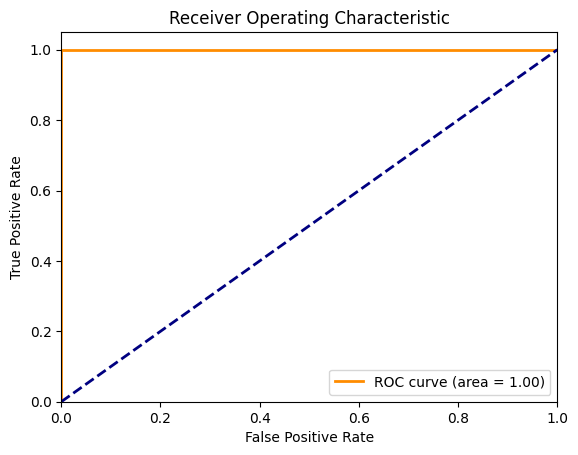

In [31]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, roc_curve
import matplotlib.pyplot as plt

# 원본 데이터와 생성된 데이터 로드
original_data = pd.read_csv("/content/drive/MyDrive/BITamin Final Project - Dacon/adult.csv")
synthetic_data = pd.read_csv("/content/drive/MyDrive/adult_output_CTABGAN.csv")

# 라벨 추가 (원본 데이터: 0, 생성된 데이터: 1)
original_data['label'] = 0
synthetic_data['label'] = 1

# 두 데이터셋 결합
combined_data = pd.concat([original_data, synthetic_data], ignore_index=True)

# 범주형 컬럼과 연속형 컬럼 구분
categorical_columns = ['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'native-country', 'income']
numerical_columns = [col for col in combined_data.columns if col not in categorical_columns and col != 'label']

def preprocess_data(df):
    # 범주형 열을 문자열로 변환
    for column in categorical_columns:
        df[column] = df[column].astype(str)

    # 원-핫 인코딩
    encoder = OneHotEncoder(sparse=False, drop='first')
    encoded_categorical = encoder.fit_transform(df[categorical_columns])

    # 연속형 데이터 스케일링
    scaler = StandardScaler()
    scaled_numerical = scaler.fit_transform(df[numerical_columns])

    # 인코딩된 데이터와 스케일된 데이터 합치기
    X = np.hstack((encoded_categorical, scaled_numerical))
    y = df['label'].values

    return X, y

X, y = preprocess_data(combined_data)

# 학습용과 테스트용 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 로지스틱 회귀 분류기 학습
classifier = LogisticRegression(max_iter=1000)
classifier.fit(X_train, y_train)

# 테스트 데이터로 예측
y_pred = classifier.predict(X_test)
y_pred_prob = classifier.predict_proba(X_test)[:, 1]

# 모델 성능 평가
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_prob)

# 결과 출력
print(f'Accuracy: {accuracy}')
print(f'Classification Report:\n{report}')
print(f'Confusion Matrix:\n{conf_matrix}')
print(f'ROC AUC Score: {roc_auc}')

# ROC 곡선 그리기
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()



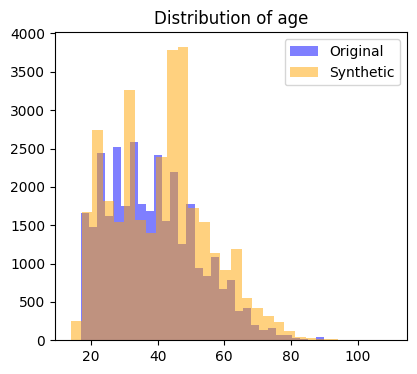

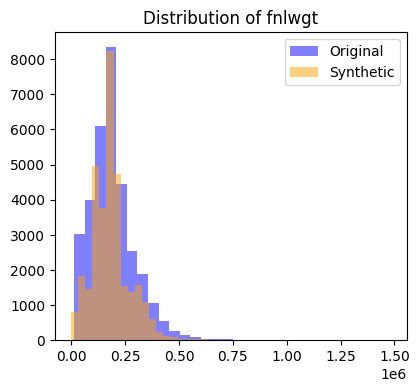

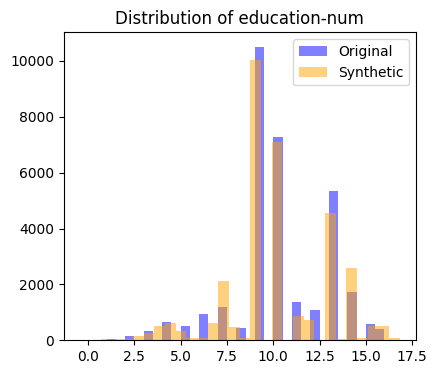

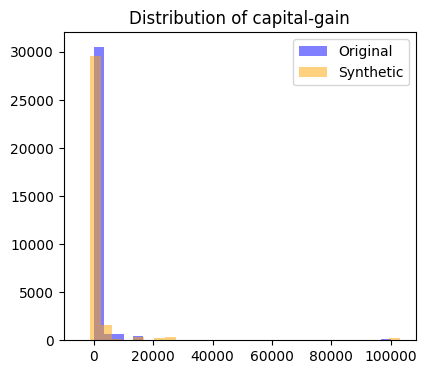

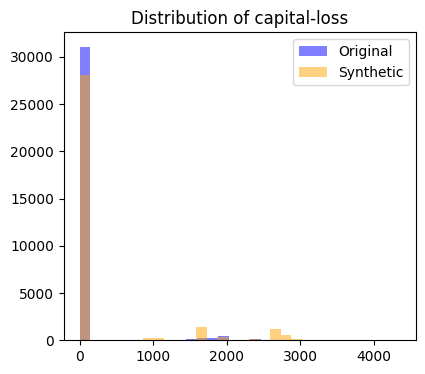

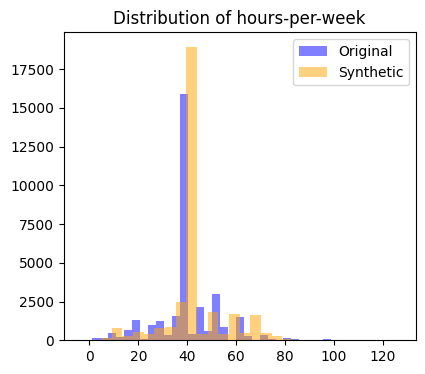

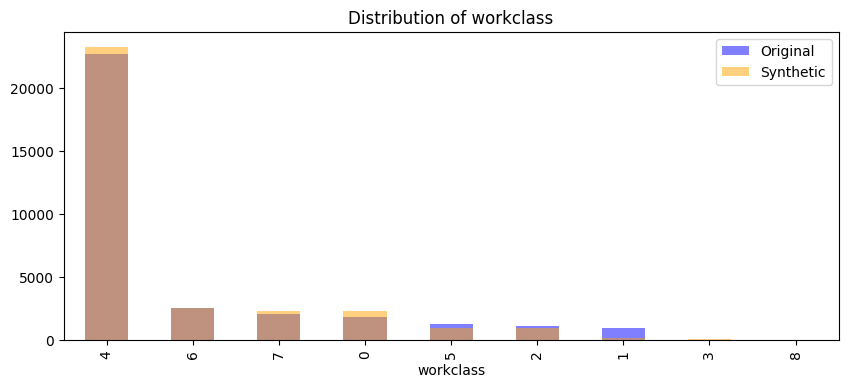

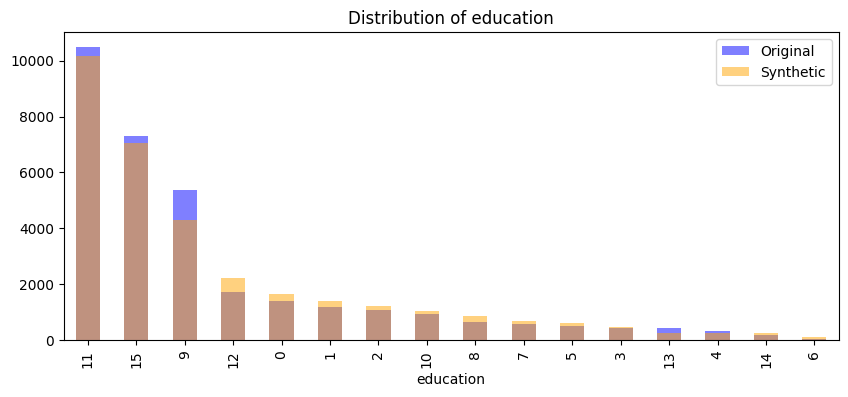

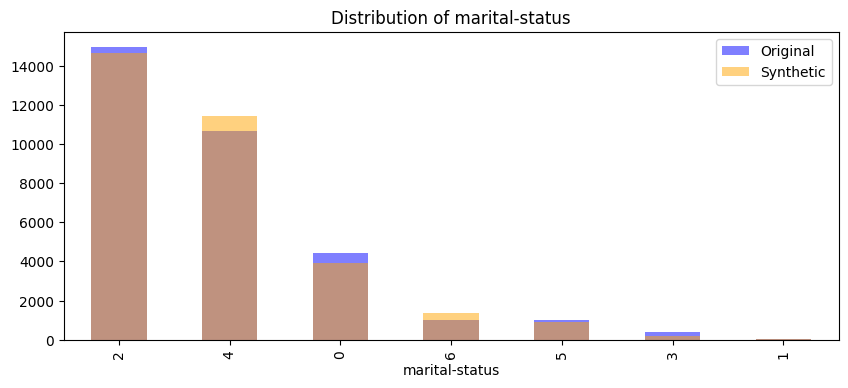

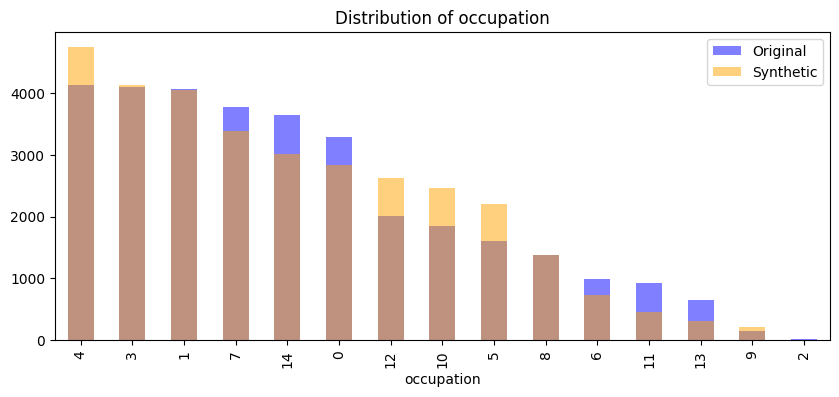

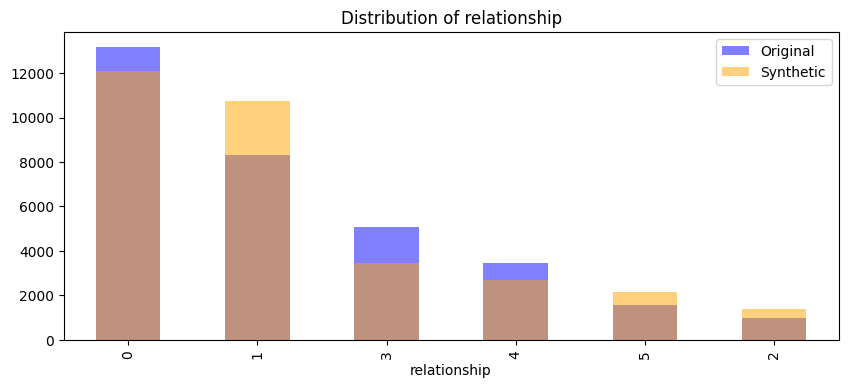

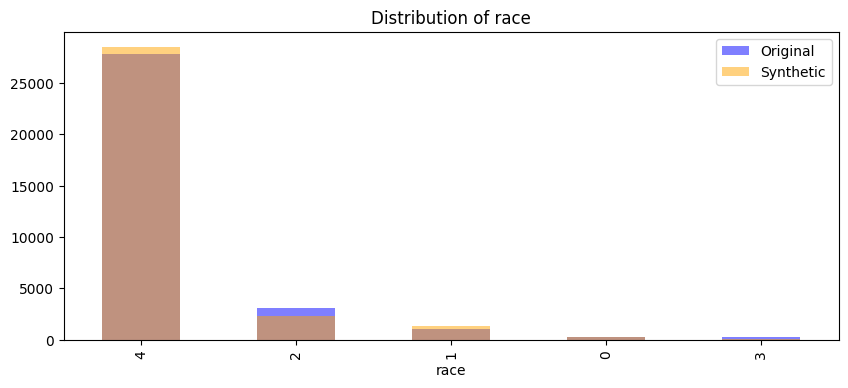

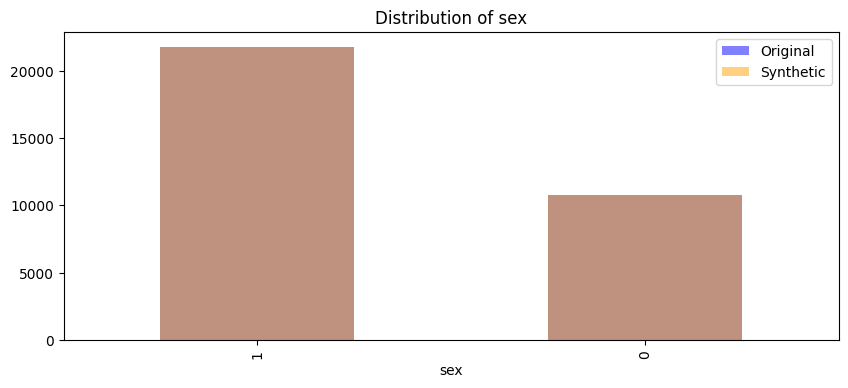

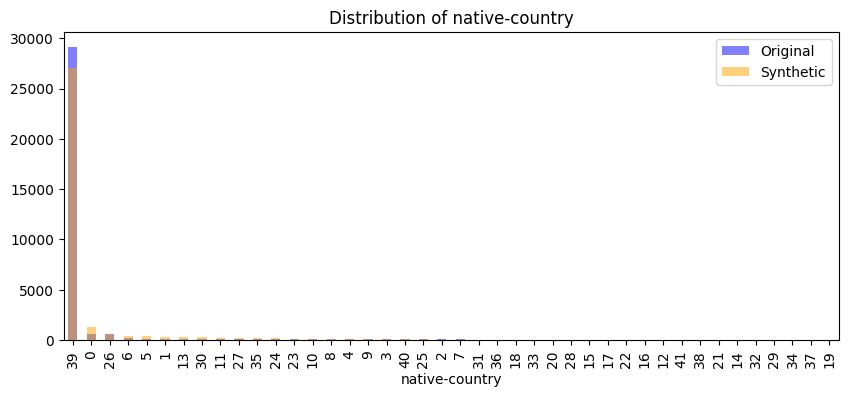

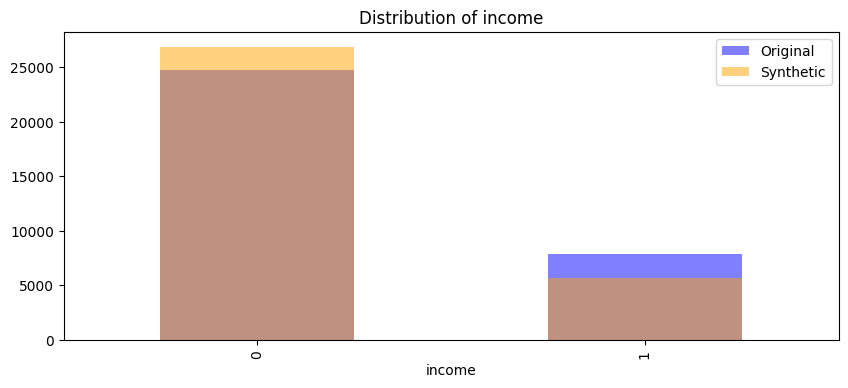

In [29]:
import matplotlib.pyplot as plt

# 데이터 분포 시각화
def plot_distributions(original, synthetic, columns, kind='hist'):
    for col in columns:
        plt.figure(figsize=(10, 4))
        plt.subplot(1, 2, 1)
        if kind == 'hist':
            plt.hist(original[col], bins=30, alpha=0.5, label='Original', color='blue')
            plt.hist(synthetic[col], bins=30, alpha=0.5, label='Synthetic', color='orange')
        elif kind == 'box':
            plt.boxplot([original[col], synthetic[col]], labels=['Original', 'Synthetic'])
        plt.title(f'Distribution of {col}')
        plt.legend()
        plt.show()

# 연속형 데이터 분포 시각화
plot_distributions(original_data, synthetic_data, numerical_columns, kind='hist')

# 범주형 데이터 분포 시각화
for col in categorical_columns:
    plt.figure(figsize=(10, 4))
    original_data[col].value_counts().plot(kind='bar', alpha=0.5, label='Original', color='blue')
    synthetic_data[col].value_counts().plot(kind='bar', alpha=0.5, label='Synthetic', color='orange')
    plt.title(f'Distribution of {col}')
    plt.legend()
    plt.show()